In [1]:
import tifffile
from pathlib import Path as P
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from skimage.feature import match_template

import pandas as pd


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
class C:
    fol_path_crops = P('/home/vitoz/Data/SegData/basel_zuri/ilastik_random_combined')
    fol_path_full = P('/home/vitoz/Data/SegData/basel_zuri/analysis_stacks')

In [3]:
file_paths_crop = list(C.fol_path_crops.glob('*_ilastik2_crop250.tiff'))
file_paths_full = [C.fol_path_full / fn.name.replace('_crop250.tiff', '.tiff') for fn in file_paths_crop]

In [4]:
file_paths_full[0]

PosixPath('/home/vitoz/Data/SegData/basel_zuri/analysis_stacks/BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_78_442_X16Y5_379_a0_ilastik2.tiff')

In [5]:
assert all([fn.exists() for fn in file_paths_full])

In [6]:
fp_crop = file_paths_crop[1]
fp_full = file_paths_full[1]

In [7]:
im_crop = tifffile.imread(str(fp_crop),out = 'memmap')[-1]
im_full = tifffile.imread(str(fp_full),out = 'memmap')[-1]

In [8]:
result = match_template(im_full, im_crop)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

In [9]:
result.max()

0.9999999565046196

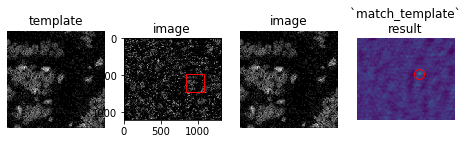

In [10]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 4, 1)
ax2 = plt.subplot(1, 4, 2)
ax4 = plt.subplot(1, 4, 3)
ax3 = plt.subplot(1, 4, 4, sharex=ax2, sharey=ax2)

ax1.imshow(im_crop, cmap=plt.cm.gray,norm=colors.PowerNorm(gamma=1/2))
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(im_full, cmap=plt.cm.gray, norm=colors.PowerNorm(gamma=1/2))
#ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = im_crop.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)


ax4.imshow(im_full[y:(y+hcoin), x:(x+wcoin)], cmap=plt.cm.gray, norm=colors.PowerNorm(gamma=1/2))
ax4.set_axis_off()
ax4.set_title('image')

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [11]:
def get_crop_coordinates(img_crop, img_full):
    result = match_template(img_full, img_crop)
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    w, h = img_crop.shape
    return x, y, w, h, result.max()



In [14]:
%%time
out_list = []
for fn_crop, fn_full in zip(file_paths_crop, file_paths_full):
    im_crop = tifffile.imread(str(fn_crop),out = 'memmap')[-1]
    im_full = tifffile.imread(str(fn_full),out = 'memmap')[-1]
    x, y, w, h, score = get_crop_coordinates(im_crop, im_full)
    out_list.append({
        'basename': fn_full.name.replace('_ilastik2.tiff',''),
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'score': score
    })
    print(out_list[-1])

{'basename': 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_78_442_X16Y5_379_a0', 'x': 1103, 'y': 1011, 'w': 250, 'h': 250, 'score': 0.9999999933048855}
{'basename': 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_57_000246_X7Y6_229_a0', 'x': 840, 'y': 476, 'w': 250, 'h': 250, 'score': 0.9999999565046196}
{'basename': 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_372_B08.37798_Cy15x4_457_a0', 'x': 684, 'y': 231, 'w': 250, 'h': 250, 'score': 0.9999999590190901}
{'basename': 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_291_B98.21413_Cy5x3_278_a0', 'x': 75, 'y': 35, 'w': 250, 'h': 250, 'score': 1.0000000938025655}
{'basename': 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_82_B07.23615_Ay11x2_170_a0', 'x': 694, 'y': 355, 'w': 250, 'h': 250, 'score': 1.0000000347662064}
{'basename': 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_48_000271_X6Y7_157_a0', 'x': 931, 'y': 598, 'w': 250, 'h': 250, 'score': 1.0000000141946337}
{'basename': 'ZTMA208_slide_20.73kx22.16ky_

In [15]:
pd.DataFrame(out_list).to_csv('../../resources/manual_coordinates.csv', index=False)